In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = ['Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)', 
            'Part Net Weight (g)', 'Surface Treatment cost (€/Part)', 
            'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)']

cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment', 'Raw Material']

# Handle missing values
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'
# Apply square root transformations
for col in num_cols:
    df[col] = np.sqrt(df[col])
df[TARGET] = np.sqrt(df['Total cost with amortization (€/part)'])

# Prepare model inputs
X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Initialize model with specified parameters
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=1,
    cat_features=cat_indices,
    early_stopping_rounds=20,
    verbose=False
)

# K-Fold validation setup
kf = KFold(n_splits=3, shuffle=True, random_state=42)
metrics = {'MAE': [], 'MAPE': [], 'RMSE': []}
violation_count = 0

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_pred_orig = np.square(y_pred)
    y_test_orig = np.square(y_test)
    
    # Calculate metrics on original scale
    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_orig))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100)
    
    # Check cost constraint violations
    cost_components = ['Surface Treatment cost (€/Part)', 
                      'Final Raw Material cost (€/Part)', 
                      'Heat Treatment cost (€/Part)']
    
    # Inverse transform cost components and sum
    sum_costs = np.sum(np.square(X_test[cost_components]), axis=1)
    violation_count += np.sum(y_pred_orig < sum_costs)

# Calculate average metrics
avg_mae = np.mean(metrics['MAE'])
avg_mape = np.mean(metrics['MAPE'])
avg_rmse = np.mean(metrics['RMSE'])


# Print final results with formatting
print("\n=== Model Evaluation Metrics ===")
print(f"Mean Absolute Error (MAE): €{avg_mae:.2f} per part")
print(f"Root Mean Squared Error (RMSE): €{avg_rmse:.2f} per part")
print(f"Mean Absolute Percentage Error (MAPE): {avg_mape:.2f}%")

print("\n=== Cost Constraint Validation ===")
print(f"Violations of cost floor: {violation_count} cases")
print(f"Violation percentage: {violation_count/len(X)*100:.2f}% of total predictions")

print("\n=== Key Statistics ===")
print(f"Total samples analyzed: {len(X)}")
print(f"Average component cost sum: €{np.mean(np.sum(np.square(X[cost_components]), axis=1)):.2f}")
print(f"Average predicted cost: €{np.mean(y_pred_orig):.2f}")



=== Model Evaluation Metrics ===
Mean Absolute Error (MAE): €0.10 per part
Root Mean Squared Error (RMSE): €0.30 per part
Mean Absolute Percentage Error (MAPE): 47.74%

=== Cost Constraint Validation ===
Violations of cost floor: 11 cases
Violation percentage: 6.92% of total predictions

=== Key Statistics ===
Total samples analyzed: 159
Average component cost sum: €0.20
Average predicted cost: €0.25


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]

cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

# Handle missing values
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'

# Apply square root transformations
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

# Check actual data violations
cost_components = ['Surface Treatment cost (€/Part)', 
                  'Final Raw Material cost (€/Part)', 
                  'Heat Treatment cost (€/Part)']
actual_sum = np.sum(df[cost_components]**2, axis=1)
actual_violations = np.sum(df[TARGET]**2 < actual_sum)
print(f"Original data violations: {actual_violations} ({actual_violations/len(df)*100:.2f}%)\n")

# Prepare model inputs
X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Set monotonic constraints (1 = positive relationship)
monotone_constraints = [
    1 if col in cost_components else 0 
    for col in X.columns
]

# Model configuration
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=1,
    cat_features=cat_indices,
    monotone_constraints=monotone_constraints,
    early_stopping_rounds=20,
    verbose=False
)

# K-Fold validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
metrics = {'MAE': [], 'MAPE': [], 'RMSE': []}
prediction_violations = 0

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_pred_orig = y_pred ** 2
    y_test_orig = y_test ** 2
    
    # Calculate metrics
    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_orig))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100)
    
    # Check prediction violations
    sum_costs = np.sum(X_test[cost_components]**2, axis=1)
    prediction_violations += np.sum(y_pred_orig < sum_costs)

# Calculate averages
avg_mae = np.mean(metrics['MAE'])
avg_mape = np.mean(metrics['MAPE'])
avg_rmse = np.mean(metrics['RMSE'])

# Print results
print("=== Model Performance ===")
print(f"MAE: €{avg_mae:.2f}")
print(f"RMSE: €{avg_rmse:.2f}")
print(f"MAPE: {avg_mape:.2f}%\n")

print("=== Constraint Validation ===")
print(f"Predicted violations: {prediction_violations} ({prediction_violations/len(X)*100:.2f}%)")
print(f"Average component sum: €{np.mean(actual_sum):.2f}")
print(f"Average predicted cost: €{np.mean(y_pred_orig):.2f}")


Original data violations: 0 (0.00%)



KeyboardInterrupt: 

In [13]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import (mean_absolute_error, 
                            mean_squared_error,
                            r2_score)

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]

cat_cols = [
    'Production', 'Raw Material Designation', 
    'Surface Treatment', 'Raw Material'
]

# Handle missing values
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Apply square root transformations
TARGET = 'Total cost with amortization (€/part)'
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Configure monotonic constraints
cost_components = ['Surface Treatment cost (€/Part)',
                   'Final Raw Material cost (€/Part)',
                   'Heat Treatment cost (€/Part)']
monotonic_constraints = [
    1 if col in cost_components else 0 
    for col in X.columns
]

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
        'border_count': trial.suggest_int('border_count', 64, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 30),
        'grow_policy': 'SymmetricTree',
        'bootstrap_type': 'MVS',
        'monotone_constraints': monotonic_constraints,
        'verbose': False
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = CatBoostRegressor(**params, cat_features=cat_indices)
        model.fit(X_train, y_train, eval_set=(X_val, y_val),
                  early_stopping_rounds=20, verbose=False)
        
        y_pred = model.predict(X_val)
        y_pred_orig = np.square(y_pred)
        y_val_orig = np.square(y_val)
        
        # Apply constraint enforcement
        sum_costs = np.sum(np.square(X_val[cost_components]), axis=1)
        y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
        
        mape = np.mean(np.abs((y_val_orig - y_pred_clipped) / y_val_orig)) * 100
        mape_scores.append(mape)
        
    return np.mean(mape_scores)

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
best_params['monotone_constraints'] = monotonic_constraints
print("\nBest parameters:", best_params)

# Extended validation with 10-fold CV
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

for fold, (train_idx, test_idx) in enumerate(kf10.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, verbose=False)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_orig = np.square(y_pred)
    y_test_orig = np.square(y_test)
    
    # Calculate component sums
    sum_costs = np.sum(np.square(X_test[cost_components]), axis=1)
    
    # Track violations
    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)
    
    # Store metrics
    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped)/y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))
    
    # Plot learning curve for last fold
    if fold == 9:
        plt.figure(figsize=(10, 6))
        plt.plot(model.get_evals_result()['learn']['MAE'], label='Train MAE')
        if 'validation' in model.get_evals_result():
            plt.plot(model.get_evals_result()['validation']['MAE'], label='Validation MAE')
        plt.title('Learning Curve - MAE Progression')
        plt.xlabel('Iterations')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()

# Aggregate results
print("\n=== Final Validation Results ===")
print(f"MAE: {np.mean(metrics['MAE']):.2f} ± {np.std(metrics['MAE']):.2f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.2f} ± {np.std(metrics['RMSE']):.2f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.2f} ± {np.std(metrics['R2']):.2f}")
print(f"Violations before clipping: {sum(metrics['violations_before'])} ({sum(metrics['violations_before'])/len(X)*100:.2f}%)")
print(f"Violations after clipping: {sum(metrics['violations_after'])} ({sum(metrics['violations_after'])/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {sum(metrics['within_10%'])/len(X)*100:.2f}%")


[I 2025-05-29 00:27:44,933] A new study created in memory with name: no-name-08128ef8-c1c6-427f-9b0e-c2d300972a5b


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-29 00:29:01,283] Trial 0 finished with value: 41.752368668684184 and parameters: {'iterations': 362, 'learning_rate': 0.06352955018720326, 'depth': 6, 'l2_leaf_reg': 4.7440034915924505, 'border_count': 251, 'min_data_in_leaf': 17}. Best is trial 0 with value: 41.752368668684184.
[I 2025-05-29 00:30:39,154] Trial 1 finished with value: 71.52609234229952 and parameters: {'iterations': 712, 'learning_rate': 0.010259809103442897, 'depth': 4, 'l2_leaf_reg': 4.960831447720376, 'border_count': 74, 'min_data_in_leaf': 5}. Best is trial 0 with value: 41.752368668684184.
[I 2025-05-29 00:31:16,397] Trial 2 finished with value: 33.35672663997243 and parameters: {'iterations': 686, 'learning_rate': 0.20556733763012974, 'depth': 5, 'l2_leaf_reg': 6.089384656764937, 'border_count': 252, 'min_data_in_leaf': 19}. Best is trial 2 with value: 33.35672663997243.
[I 2025-05-29 00:33:14,765] Trial 3 finished with value: 46.72614356312965 and parameters: {'iterations': 778, 'learning_rate': 0.061

KeyError: 'MAE'

<Figure size 1000x600 with 0 Axes>

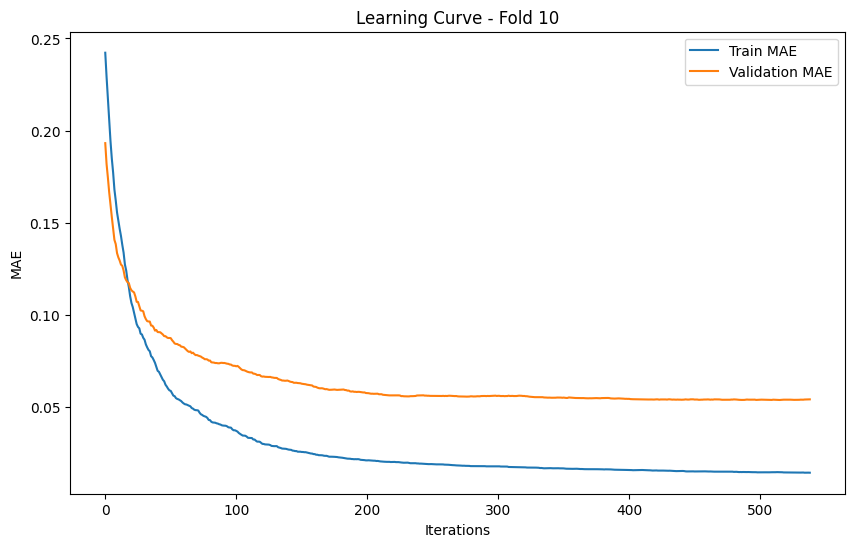

=== Final Validation Results ===
MAE: 0.07 ± 0.07
RMSE: 0.16 ± 0.16
MAPE: 34.26% ± 15.04
R²: 0.90 ± 0.08
Violations before clipping: 28 (17.61%)
Violations after clipping: 0 (0.00%)
Predictions within ±10%: 23.90%


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import (mean_absolute_error, 
                            mean_squared_error,
                            r2_score)

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]

cat_cols = [
    'Production', 'Raw Material Designation', 
    'Surface Treatment', 'Raw Material'
]

# Handle missing values
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Apply square root transformations
TARGET = 'Total cost with amortization (€/part)'
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Best parameters with fixed settings for constraints
best_params = {
    'iterations': 539,
    'learning_rate': 0.09437788775088768,
    'depth': 4,
    'l2_leaf_reg': 1.705994597015345,
    'border_count': 157,
    'min_data_in_leaf': 19,
    'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'grow_policy': 'SymmetricTree',
    'bootstrap_type': 'MVS',
    'eval_metric': 'MAE',  # Track MAE during training
    'verbose': False
}

cost_components = [
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)',
    'Heat Treatment cost (€/Part)'
]

# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_orig = np.square(y_pred)
    y_test_orig = np.square(y_test)
    
    # Calculate component costs sum (original scale)
    sum_costs = np.sum(np.square(X_test[cost_components]), axis=1)
    
    # Track violations
    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)
    
    # Calculate metrics
    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped) / y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))
    
    # Plot learning curve for last fold
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        
        # Handle different metric names
        metric_key = 'MAE' if 'MAE' in eval_results['learn'] else 'MultiOutput'
        
        plt.plot(eval_results['learn'][metric_key], label='Train MAE')
        plt.plot(eval_results['validation'][metric_key], label='Validation MAE')
        plt.title(f'Learning Curve - Fold {fold+1}')
        plt.xlabel('Iterations')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()

# Calculate averages
avg_mae = np.mean(metrics['MAE'])
avg_rmse = np.mean(metrics['RMSE'])
avg_mape = np.mean(metrics['MAPE'])
avg_r2 = np.mean(metrics['R2'])
total_violations_before = sum(metrics['violations_before'])
total_violations_after = sum(metrics['violations_after'])
within_10_percent = sum(metrics['within_10%'])

print("=== Final Validation Results ===")
print(f"MAE: {avg_mae:.2f} ± {np.std(metrics['MAE']):.2f}")
print(f"RMSE: {avg_rmse:.2f} ± {np.std(metrics['RMSE']):.2f}")
print(f"MAPE: {avg_mape:.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {avg_r2:.2f} ± {np.std(metrics['R2']):.2f}")
print(f"Violations before clipping: {total_violations_before} ({total_violations_before/len(X)*100:.2f}%)")
print(f"Violations after clipping: {total_violations_after} ({total_violations_after/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {within_10_percent/len(X)*100:.2f}%")


In [16]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply square root transformations
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

cost_components = ['Surface Treatment cost (€/Part)',
                   'Final Raw Material cost (€/Part)',
                   'Heat Treatment cost (€/Part)']
monotonic_constraints = [
    1 if col in cost_components else 0
    for col in X.columns
]

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'depth': trial.suggest_int('depth', 4, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 30.0),
        'border_count': trial.suggest_int('border_count', 64, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        'random_strength': trial.suggest_float('random_strength', 0.1, 5.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'grow_policy': 'SymmetricTree',
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['MVS', 'Bernoulli']),
        'feature_border_type': trial.suggest_categorical('feature_border_type', ['GreedyLogSum', 'MaxLogSum', 'MinEntropy']),
        'monotone_constraints': monotonic_constraints,
        'eval_metric': 'MAE',
        'verbose': False
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(**params, cat_features=cat_indices)
        model.fit(X_train, y_train, eval_set=(X_val, y_val),
                  early_stopping_rounds=20, verbose=False)

        y_pred = model.predict(X_val)
        y_pred_orig = np.square(y_pred)
        y_val_orig = np.square(y_val)

        # Apply constraint enforcement
        sum_costs = np.sum(np.square(X_val[cost_components]), axis=1)
        y_pred_clipped = np.maximum(y_pred_orig, sum_costs)

        mape = np.mean(np.abs((y_val_orig - y_pred_clipped) / y_val_orig)) * 100
        mape_scores.append(mape)

    return np.mean(mape_scores)

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
best_params['grow_policy'] = 'SymmetricTree'
best_params['monotone_constraints'] = monotonic_constraints
print("\nBest parameters:", best_params)

# Extended validation with 10-fold CV
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

for fold, (train_idx, test_idx) in enumerate(kf10.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

    y_pred = model.predict(X_test)
    y_pred_orig = np.square(y_pred)
    y_test_orig = np.square(y_test)

    sum_costs = np.sum(np.square(X_test[cost_components]), axis=1)

    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)

    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped)/y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))

    # Plot learning curve for last fold
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        # CatBoost always uses 'learn' and 'validation' as keys if eval_set is provided
        plt.plot(eval_results['learn']['MAE'], label='Train MAE')
        if 'validation' in eval_results:
            plt.plot(eval_results['validation']['MAE'], label='Validation MAE')
        plt.title('Learning Curve - MAE Progression')
        plt.xlabel('Iterations')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()

# Aggregate results
print("\n=== Final Validation Results ===")
print(f"MAE: {np.mean(metrics['MAE']):.2f} ± {np.std(metrics['MAE']):.2f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.2f} ± {np.std(metrics['RMSE']):.2f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.2f} ± {np.std(metrics['R2']):.2f}")
print(f"Violations before clipping: {sum(metrics['violations_before'])} ({sum(metrics['violations_before'])/len(X)*100:.2f}%)")
print(f"Violations after clipping: {sum(metrics['violations_after'])} ({sum(metrics['violations_after'])/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {sum(metrics['within_10%'])/len(X)*100:.2f}%")


[I 2025-05-29 10:34:59,539] A new study created in memory with name: no-name-919b086c-bdc5-49f9-bb00-03edc933c63b


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-29 10:38:51,746] Trial 0 finished with value: 137.14078558933616 and parameters: {'iterations': 913, 'learning_rate': 0.011404960818113895, 'depth': 6, 'l2_leaf_reg': 28.866758525861293, 'border_count': 175, 'min_data_in_leaf': 23, 'random_strength': 1.8760946881846843, 'subsample': 0.8441133569941155, 'bootstrap_type': 'MVS', 'feature_border_type': 'MaxLogSum'}. Best is trial 0 with value: 137.14078558933616.
[I 2025-05-29 10:42:52,515] Trial 1 finished with value: 46.59308896943033 and parameters: {'iterations': 931, 'learning_rate': 0.04988820521395206, 'depth': 5, 'l2_leaf_reg': 28.775186214052376, 'border_count': 140, 'min_data_in_leaf': 30, 'random_strength': 3.3611993275571956, 'subsample': 0.9324508042763275, 'bootstrap_type': 'Bernoulli', 'feature_border_type': 'MaxLogSum'}. Best is trial 1 with value: 46.59308896943033.
[I 2025-05-29 10:50:48,112] Trial 2 finished with value: 63.83516651678052 and parameters: {'iterations': 1057, 'learning_rate': 0.0141627561718237

KeyError: 'MAE'

<Figure size 1000x600 with 0 Axes>

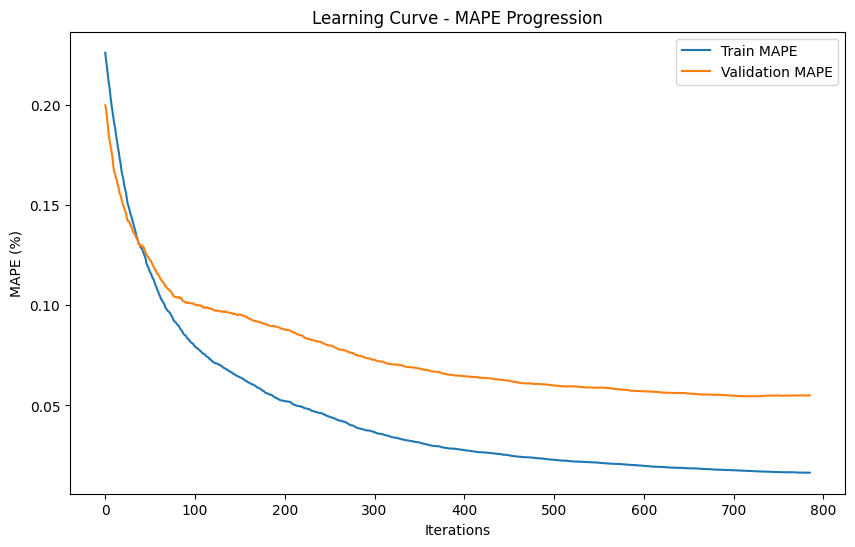


=== Final Validation Results ===
MAE: 0.07 ± 0.07
RMSE: 0.16 ± 0.16
MAPE: 34.29% ± 15.32
R²: 0.89 ± 0.10
Violations before clipping: 12 (7.55%)
Violations after clipping: 0 (0.00%)
Predictions within ±10%: 31.45%


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply square root transformations
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Best parameters with MAPE tracking
best_params = {
    'iterations': 786,
    'learning_rate': 0.0317,
    'depth': 5,
    'l2_leaf_reg': 2.216,
    'border_count': 83,
    'min_data_in_leaf': 34,
    'random_strength': 1.742,
    'subsample': 0.940,
    'bootstrap_type': 'Bernoulli',
    'feature_border_type': 'MaxLogSum',
    'grow_policy': 'SymmetricTree',
    'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'eval_metric': 'MAPE',  # Track MAPE during training
    'verbose': False
}

cost_components = [
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)',
    'Heat Treatment cost (€/Part)'
]

# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_orig = np.square(y_pred)
    y_test_orig = np.square(y_test)
    
    # Calculate component costs sum
    sum_costs = np.sum(np.square(X_test[cost_components]), axis=1)
    
    # Track violations
    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)
    
    # Store metrics
    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped)/y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))
    
    # Plot learning curve for last fold (MAPE based)
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        
        # Plot MAPE curves
        plt.plot(eval_results['learn']['MAPE'], label='Train MAPE')
        plt.plot(eval_results['validation']['MAPE'], label='Validation MAPE')
        plt.title('Learning Curve - MAPE Progression')
        plt.xlabel('Iterations')
        plt.ylabel('MAPE (%)')
        plt.legend()
        plt.show()

# Print results
print("\n=== Final Validation Results ===")
print(f"MAE: {np.mean(metrics['MAE']):.2f} ± {np.std(metrics['MAE']):.2f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.2f} ± {np.std(metrics['RMSE']):.2f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.2f} ± {np.std(metrics['R2']):.2f}")
print(f"Violations before clipping: {sum(metrics['violations_before'])} ({sum(metrics['violations_before'])/len(X)*100:.2f}%)")
print(f"Violations after clipping: {sum(metrics['violations_after'])} ({sum(metrics['violations_after'])/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {sum(metrics['within_10%'])/len(X)*100:.2f}%")


In [19]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply square root transformations
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

cost_components = ['Surface Treatment cost (€/Part)',
                   'Final Raw Material cost (€/Part)',
                   'Heat Treatment cost (€/Part)']
monotonic_constraints = [
    1 if col in cost_components else 0
    for col in X.columns
]

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 600),  # Reduced range
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.02, log=True),  # Much lower
        'depth': trial.suggest_int('depth', 3, 6),  # Shallower trees
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5.0, 50.0),  # Stronger regularization
        'border_count': trial.suggest_int('border_count', 32, 128),  # Reduced
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 50),  # Higher minimum
        'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),  # More conservative
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),  # Lower subsample
        'grow_policy': 'SymmetricTree',
        'bootstrap_type': 'Bernoulli',  # Fixed - better for small datasets
        'feature_border_type': 'GreedyLogSum',  # Fixed - most stable
        'monotone_constraints': monotonic_constraints,
        'early_stopping_rounds': 30,  # Earlier stopping
        'eval_metric': 'MAPE',
        'verbose': False
    }


    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(**params, cat_features=cat_indices)
        model.fit(X_train, y_train, eval_set=(X_val, y_val),
                  early_stopping_rounds=20, verbose=False)

        y_pred = model.predict(X_val)
        y_pred_orig = np.square(y_pred)
        y_val_orig = np.square(y_val)

        # Apply constraint enforcement
        sum_costs = np.sum(np.square(X_val[cost_components]), axis=1)
        y_pred_clipped = np.maximum(y_pred_orig, sum_costs)

        mape = np.mean(np.abs((y_val_orig - y_pred_clipped) / y_val_orig)) * 100
        mape_scores.append(mape)

    return np.mean(mape_scores)

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
best_params['grow_policy'] = 'SymmetricTree'
best_params['monotone_constraints'] = monotonic_constraints
print("\nBest parameters:", best_params)

# Extended validation with 10-fold CV
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

for fold, (train_idx, test_idx) in enumerate(kf10.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

    y_pred = model.predict(X_test)
    y_pred_orig = np.square(y_pred)
    y_test_orig = np.square(y_test)

    sum_costs = np.sum(np.square(X_test[cost_components]), axis=1)

    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)

    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped)/y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))

    # Plot learning curve for last fold
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        # CatBoost always uses 'learn' and 'validation' as keys if eval_set is provided
        plt.plot(eval_results['learn']['MAE'], label='Train MAE')
        if 'validation' in eval_results:
            plt.plot(eval_results['validation']['MAE'], label='Validation MAE')
        plt.title('Learning Curve - MAE Progression')
        plt.xlabel('Iterations')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()

# Aggregate results
print("\n=== Final Validation Results ===")
print(f"MAE: {np.mean(metrics['MAE']):.2f} ± {np.std(metrics['MAE']):.2f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.2f} ± {np.std(metrics['RMSE']):.2f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.2f} ± {np.std(metrics['R2']):.2f}")
print(f"Violations before clipping: {sum(metrics['violations_before'])} ({sum(metrics['violations_before'])/len(X)*100:.2f}%)")
print(f"Violations after clipping: {sum(metrics['violations_after'])} ({sum(metrics['violations_after'])/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {sum(metrics['within_10%'])/len(X)*100:.2f}%")


[I 2025-05-29 17:37:08,893] A new study created in memory with name: no-name-b942550a-9f73-4646-b253-28ab6b133aeb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-29 17:38:22,617] Trial 0 finished with value: 135.08867475646727 and parameters: {'iterations': 387, 'learning_rate': 0.013041755814337799, 'depth': 4, 'l2_leaf_reg': 11.665227634127831, 'border_count': 115, 'min_data_in_leaf': 40, 'random_strength': 1.8470273231946155, 'subsample': 0.5506163836053268}. Best is trial 0 with value: 135.08867475646727.
[I 2025-05-29 17:39:43,481] Trial 1 finished with value: 201.38678587534906 and parameters: {'iterations': 374, 'learning_rate': 0.008895806451972042, 'depth': 5, 'l2_leaf_reg': 23.299685364357966, 'border_count': 99, 'min_data_in_leaf': 21, 'random_strength': 1.4476899740756903, 'subsample': 0.6070054670545872}. Best is trial 0 with value: 135.08867475646727.
[I 2025-05-29 17:41:28,948] Trial 2 finished with value: 162.47876591740905 and parameters: {'iterations': 425, 'learning_rate': 0.008830080608156484, 'depth': 6, 'l2_leaf_reg': 11.680685388405427, 'border_count': 75, 'min_data_in_leaf': 41, 'random_strength': 1.9617244654

KeyError: 'MAE'

<Figure size 1000x600 with 0 Axes>

In [1]:

import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply square root transformations
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

cost_components = ['Surface Treatment cost (€/Part)',
                   'Final Raw Material cost (€/Part)',
                   'Heat Treatment cost (€/Part)']
monotonic_constraints = [
    1 if col in cost_components else 0
    for col in X.columns
]

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 600, 1200),  # Increase range
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.06, log=True),  # Higher range
        'depth': trial.suggest_int('depth', 4, 7),  # Slightly deeper
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),  # Less regularization
        'border_count': trial.suggest_int('border_count', 50, 150),  # Wider range
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 25),  # Lower minimum
        'random_strength': trial.suggest_float('random_strength', 1.0, 3.0),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),  # Higher subsample
        'grow_policy': 'SymmetricTree',
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'MVS']),
        'feature_border_type': trial.suggest_categorical('feature_border_type', ['MaxLogSum', 'GreedyLogSum']),
        'monotone_constraints': monotonic_constraints,
        'eval_metric': 'MAPE',
        'verbose': False
    }



    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(**params, cat_features=cat_indices)
        model.fit(X_train, y_train, eval_set=(X_val, y_val),
                  early_stopping_rounds=20, verbose=False)

        y_pred = model.predict(X_val)
        y_pred_orig = np.square(y_pred)
        y_val_orig = np.square(y_val)

        # Apply constraint enforcement
        sum_costs = np.sum(np.square(X_val[cost_components]), axis=1)
        y_pred_clipped = np.maximum(y_pred_orig, sum_costs)

        mape = np.mean(np.abs((y_val_orig - y_pred_clipped) / y_val_orig)) * 100
        mape_scores.append(mape)

    return np.mean(mape_scores)

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
best_params['grow_policy'] = 'SymmetricTree'
best_params['monotone_constraints'] = monotonic_constraints
print("\nBest parameters:", best_params)

# Extended validation with 10-fold CV
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

for fold, (train_idx, test_idx) in enumerate(kf10.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

    y_pred = model.predict(X_test)
    y_pred_orig = np.square(y_pred)
    y_test_orig = np.square(y_test)

    sum_costs = np.sum(np.square(X_test[cost_components]), axis=1)

    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)

    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped)/y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))

    # Plot learning curve for last fold
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        # CatBoost always uses 'learn' and 'validation' as keys if eval_set is provided
        plt.plot(eval_results['learn']['MAE'], label='Train MAE')
        if 'validation' in eval_results:
            plt.plot(eval_results['validation']['MAE'], label='Validation MAE')
        plt.title('Learning Curve - MAE Progression')
        plt.xlabel('Iterations')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()

# Aggregate results
print("\n=== Final Validation Results ===")
print(f"MAE: {np.mean(metrics['MAE']):.2f} ± {np.std(metrics['MAE']):.2f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.2f} ± {np.std(metrics['RMSE']):.2f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.2f} ± {np.std(metrics['R2']):.2f}")
print(f"Violations before clipping: {sum(metrics['violations_before'])} ({sum(metrics['violations_before'])/len(X)*100:.2f}%)")
print(f"Violations after clipping: {sum(metrics['violations_after'])} ({sum(metrics['violations_after'])/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {sum(metrics['within_10%'])/len(X)*100:.2f}%")


[I 2025-05-30 12:00:27,427] A new study created in memory with name: no-name-088798d0-d5ea-4f90-8506-c9b1b1cd3e41


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-05-30 12:03:41,829] Trial 0 finished with value: 44.42757112184862 and parameters: {'iterations': 1183, 'learning_rate': 0.032072825227934, 'depth': 6, 'l2_leaf_reg': 8.774775689143517, 'border_count': 88, 'min_data_in_leaf': 19, 'random_strength': 1.5677676475367863, 'subsample': 0.9061003417235491, 'bootstrap_type': 'MVS', 'feature_border_type': 'GreedyLogSum'}. Best is trial 0 with value: 44.42757112184862.
[I 2025-05-30 12:05:00,035] Trial 1 finished with value: 36.3427800035752 and parameters: {'iterations': 1187, 'learning_rate': 0.047444909519162824, 'depth': 5, 'l2_leaf_reg': 2.194792891638077, 'border_count': 130, 'min_data_in_leaf': 10, 'random_strength': 1.2805072052673192, 'subsample': 0.8145811646924044, 'bootstrap_type': 'Bernoulli', 'feature_border_type': 'MaxLogSum'}. Best is trial 1 with value: 36.3427800035752.
[I 2025-05-30 12:07:06,146] Trial 2 finished with value: 49.480483282128446 and parameters: {'iterations': 711, 'learning_rate': 0.02447681872284097, '

KeyError: 'MAE'

<Figure size 1000x600 with 0 Axes>

Using fixed parameters: {'iterations': 1200, 'learning_rate': 0.05885010618981411, 'depth': 4, 'l2_leaf_reg': 1.0071636447709995, 'border_count': 150, 'min_data_in_leaf': 13, 'random_strength': 1.0604658610530202, 'subsample': 0.803615358048777, 'bootstrap_type': 'MVS', 'feature_border_type': 'GreedyLogSum', 'grow_policy': 'SymmetricTree', 'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], 'eval_metric': 'MAPE', 'verbose': False}
Fold 1/10 completed - MAPE: 16.33%
Fold 2/10 completed - MAPE: 33.45%
Fold 3/10 completed - MAPE: 35.13%
Fold 4/10 completed - MAPE: 24.68%
Fold 5/10 completed - MAPE: 41.04%
Fold 6/10 completed - MAPE: 56.03%
Fold 7/10 completed - MAPE: 28.98%
Fold 8/10 completed - MAPE: 19.23%
Fold 9/10 completed - MAPE: 55.01%
Fold 10/10 completed - MAPE: 30.33%


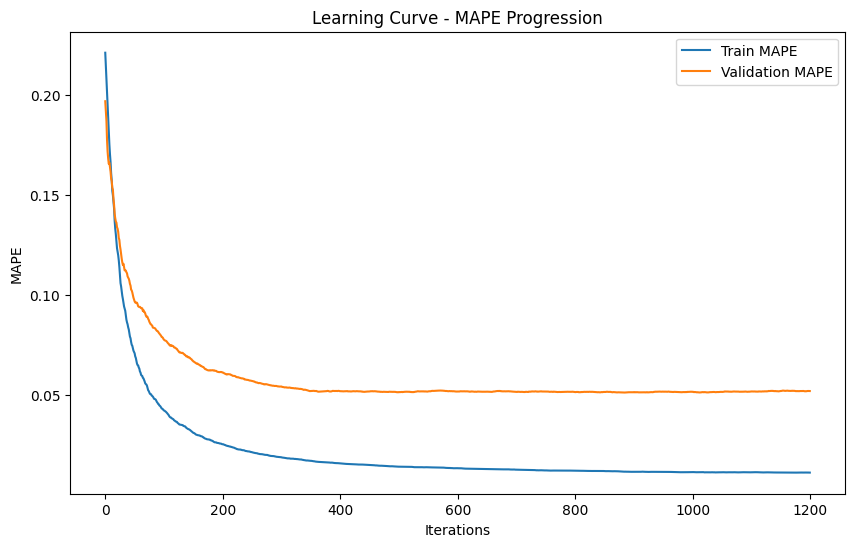


=== Final Validation Results ===
MAE: 0.08 ± 0.07
RMSE: 0.17 ± 0.15
MAPE: 34.02% ± 12.78
R²: 0.88 ± 0.10
Violations before clipping: 53 (33.33%)
Violations after clipping: 0 (0.00%)
Predictions within ±10%: 20.13%

=== Training Final Model on Full Dataset ===

Top 10 Most Important Features:
                             feature  importance
5   Final Raw Material cost (€/Part)   49.315588
4    Surface Treatment cost (€/Part)   19.015729
0             Annual target quantity   16.479980
3                Part Net Weight (g)    4.347208
2                     Thickness (mm)    3.876001
7                         Production    2.080041
10                      Raw Material    1.740059
1           Raw Material Cost (€/kg)    1.578024
9                  Surface Treatment    1.558754
6       Heat Treatment cost (€/Part)    0.008616


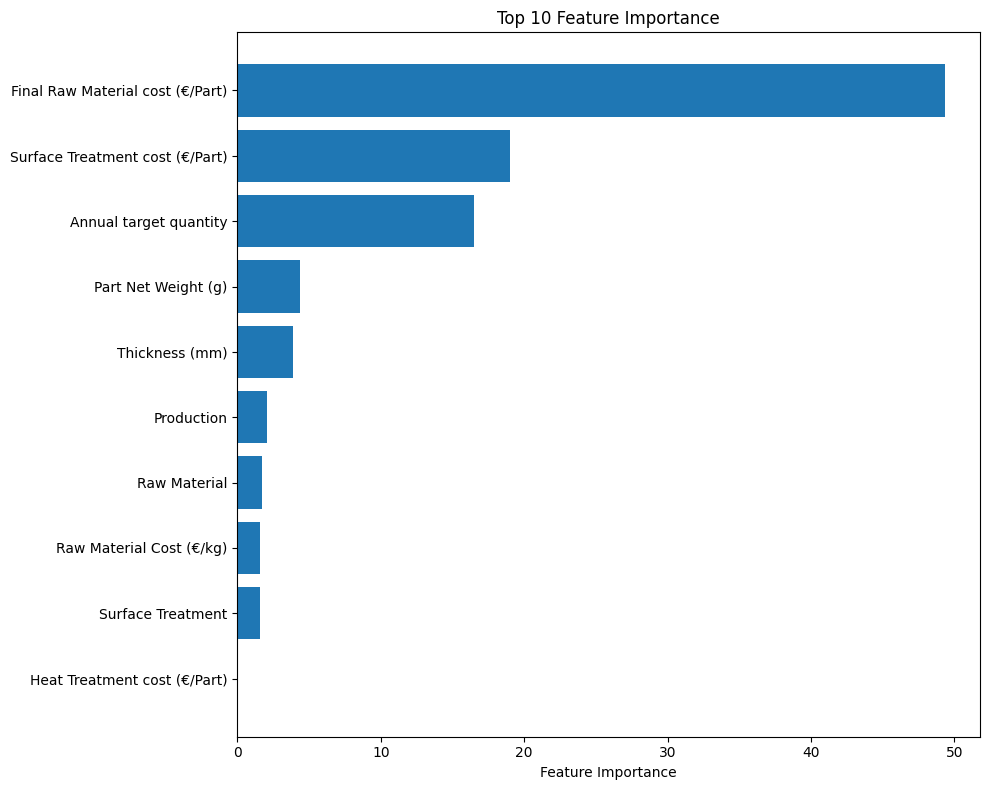

In [2]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply square root transformations
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

cost_components = ['Surface Treatment cost (€/Part)',
                   'Final Raw Material cost (€/Part)',
                   'Heat Treatment cost (€/Part)']
monotonic_constraints = [
    1 if col in cost_components else 0
    for col in X.columns
]

# Fixed best parameters
best_params = {
    'iterations': 1200,
    'learning_rate': 0.05885010618981411,
    'depth': 4,
    'l2_leaf_reg': 1.0071636447709995,
    'border_count': 150,
    'min_data_in_leaf': 13,
    'random_strength': 1.0604658610530202,
    'subsample': 0.803615358048777,
    'bootstrap_type': 'MVS',
    'feature_border_type': 'GreedyLogSum',
    'grow_policy': 'SymmetricTree',
    'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'eval_metric': 'MAPE',
    'verbose': False
}

print("Using fixed parameters:", best_params)

# Extended validation with 10-fold CV
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

for fold, (train_idx, test_idx) in enumerate(kf10.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

    y_pred = model.predict(X_test)
    y_pred_orig = np.square(y_pred)
    y_test_orig = np.square(y_test)

    sum_costs = np.sum(np.square(X_test[cost_components]), axis=1)

    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)

    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped)/y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))

    print(f"Fold {fold+1}/10 completed - MAPE: {metrics['MAPE'][-1]:.2f}%")

    # Plot learning curve for last fold
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        # CatBoost always uses 'learn' and 'validation' as keys if eval_set is provided
        plt.plot(eval_results['learn']['MAPE'], label='Train MAPE')
        if 'validation' in eval_results:
            plt.plot(eval_results['validation']['MAPE'], label='Validation MAPE')
        plt.title('Learning Curve - MAPE Progression')
        plt.xlabel('Iterations')
        plt.ylabel('MAPE')
        plt.legend()
        plt.show()

# Aggregate results
print("\n=== Final Validation Results ===")
print(f"MAE: {np.mean(metrics['MAE']):.2f} ± {np.std(metrics['MAE']):.2f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.2f} ± {np.std(metrics['RMSE']):.2f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.2f} ± {np.std(metrics['R2']):.2f}")
print(f"Violations before clipping: {sum(metrics['violations_before'])} ({sum(metrics['violations_before'])/len(X)*100:.2f}%)")
print(f"Violations after clipping: {sum(metrics['violations_after'])} ({sum(metrics['violations_after'])/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {sum(metrics['within_10%'])/len(X)*100:.2f}%")

# Optional: Train final model on full dataset for feature importance
print("\n=== Training Final Model on Full Dataset ===")
final_model = CatBoostRegressor(**best_params, cat_features=cat_indices)
final_model.fit(X, y, verbose=False)

# Feature importance
feature_importance = final_model.get_feature_importance()
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
